In [26]:
import numpy as np
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [27]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [28]:
def clean_text(row):
    return row['text']

In [29]:
spacy_model = "en_core_web_lg"
nlp = spacy.load(spacy_model, enable=["tok2vec", "tagger"])
train_text_vectors = np.array([nlp(clean_text(row)).vector for _, row in train_df.iterrows()])
test_text_vectors = np.array([nlp(clean_text(row)).vector for _, row in test_df.iterrows()])
train_labels = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(train_text_vectors, train_labels, test_size=0.1, random_state=3)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
X_test_tensor = torch.tensor(test_text_vectors, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
input_dim = train_text_vectors.shape[1]


class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) 
        self.dropout = nn.Dropout(0.3)   
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

mlp_model = MLPModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = mlp_model.to(device)
print(mlp_model)

MLPModel(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
def train(model, criterion, optimizer, num_epochs = 10):
    # Training loop with validation
    history = [[], []]
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == y_batch).sum().item()
            train_total += y_batch.size(0)
        
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predictions = (outputs > 0.5).float()
                valid_correct += (predictions == y_batch).sum().item()
                valid_total += y_batch.size(0)
        
        valid_accuracy = valid_correct / valid_total
        history[0].append((train_loss, valid_loss))
        history[1].append((train_accuracy, valid_accuracy))

        # Print epoch summary
        if (epoch + 1) % 2 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
            f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f} - "
            f"Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Acc: {valid_accuracy:.4f}")
    return history

In [32]:
def predictions(model, loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for X_batch in loader:
            X_batch = X_batch[0]
            outputs = model(X_batch).squeeze()
            batch_predictions = (outputs > 0.5).int()
            predictions.extend(batch_predictions.cpu().numpy())
    return predictions


def test():
    predictions = predictions(mlp_model, test_loader)
    submit_data = pd.DataFrame(test_df['id'])
    submit_data['target'] = predictions
    submit_data.to_csv('submission.csv', index=False)

In [33]:
def plot_accuracies_losses(history):
    t, v = zip(*history[0])
    plt.plot(t, label="Train Loss")
    plt.plot(v, label="Valid Loss")
    plt.legend()
    plt.show()
    t, v = zip(*history[1])
    plt.plot(t, label="Train Acc")
    plt.plot(v, label="Valid Acc")
    plt.legend()
    plt.show()

def confusion_matrix(model, loader, y_true):
    y_pred = predictions(model, loader)
    

Epoch [2/10] - Train Loss: 0.4511, Train Acc: 0.7997 - Valid Loss: 0.4695, Valid Acc: 0.7913
Epoch [4/10] - Train Loss: 0.4270, Train Acc: 0.8113 - Valid Loss: 0.4377, Valid Acc: 0.7992
Epoch [6/10] - Train Loss: 0.4089, Train Acc: 0.8231 - Valid Loss: 0.4310, Valid Acc: 0.8031
Epoch [8/10] - Train Loss: 0.3918, Train Acc: 0.8286 - Valid Loss: 0.4306, Valid Acc: 0.8176
Epoch [10/10] - Train Loss: 0.3788, Train Acc: 0.8370 - Valid Loss: 0.4267, Valid Acc: 0.8123


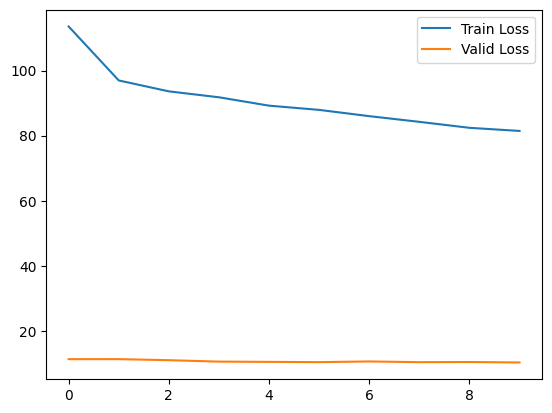

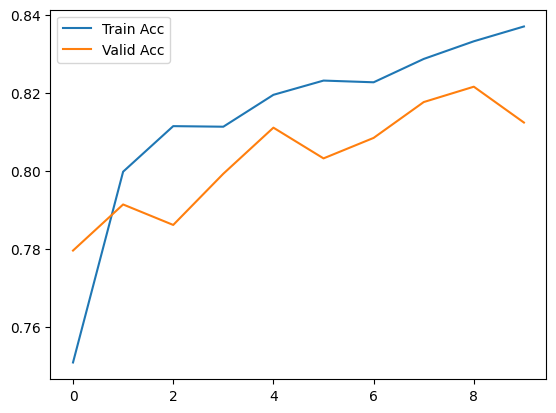

In [34]:
plot_accuracies_losses(train(mlp_model, criterion, optimizer))
test()

MLPModel(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Epoch [2/50] - Train Loss: 0.4554, Train Acc: 0.7993 - Valid Loss: 0.4501, Valid Acc: 0.7927
Epoch [4/50] - Train Loss: 0.4223, Train Acc: 0.8139 - Valid Loss: 0.4432, Valid Acc: 0.8005
Epoch [6/50] - Train Loss: 0.3962, Train Acc: 0.8291 - Valid Loss: 0.4299, Valid Acc: 0.8110
Epoch [8/50] - Train Loss: 0.3839, Train Acc: 0.8343 - Valid Loss: 0.4263, Valid Acc: 0.8123
Epoch [10/50] - Train Loss: 0.3631, Train Acc: 0.8443 - Valid Loss: 0.4309, Valid Acc: 0.8123
Epoch [12/50] - Train Loss: 0.3521, Train Acc: 0.8521 - Valid Loss: 0.4381, Valid Acc: 0.8110
Epoch [14/50] - Train Loss: 0.3385, Train Acc: 0.8610 - Valid Loss: 0.4438, Valid Acc: 0.8097
Epoch [16/50] - Train Loss: 0.3211, Train Acc: 0.8675 - Valid Loss: 0.4504, Valid Acc: 0.8097
Epoch [18/50] - T

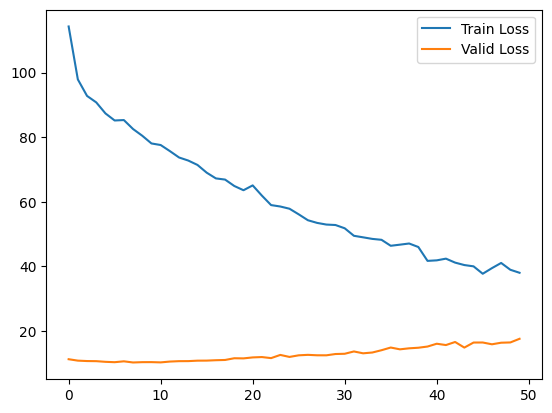

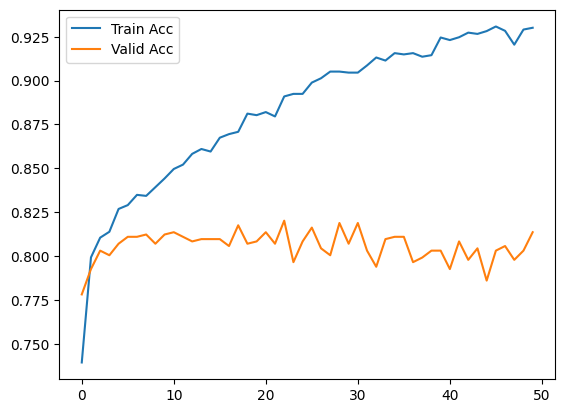

In [35]:
overcooked_model = MLPModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(overcooked_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = mlp_model.to(device)
print(overcooked_model)
plot_accuracies_losses(train(overcooked_model, criterion, optimizer, 50))